In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score

Confusion Matrix:
 [[276139   8176]
 [    85    407]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9712    0.9853    284315
           1     0.0474    0.8272    0.0897       492

    accuracy                         0.9710    284807
   macro avg     0.5236    0.8992    0.5375    284807
weighted avg     0.9980    0.9710    0.9837    284807



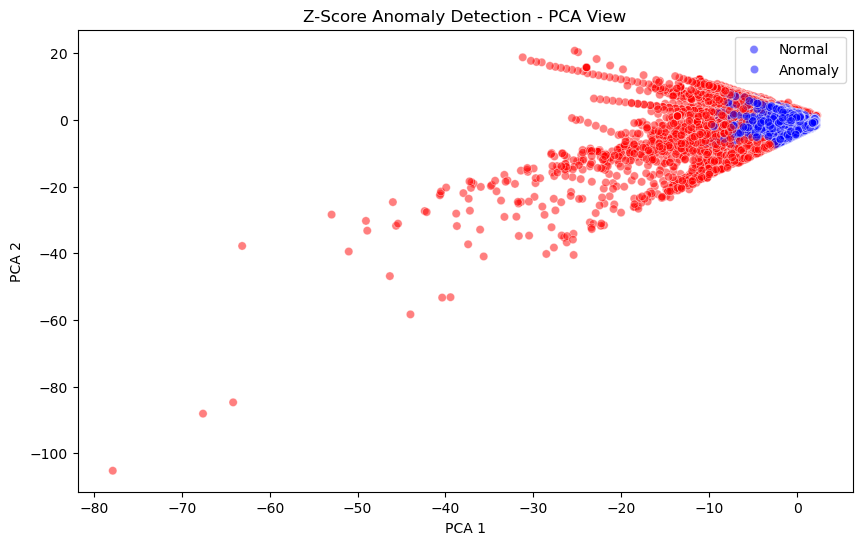


 Statistical Insights (means):
   Feature  Fraud_Mean  Normal_Mean      Diff
2       V3   -7.033281     0.012171 -7.045452
13     V14   -6.971723     0.012064 -6.983787
16     V17   -6.665836     0.011535 -6.677371
11     V12   -6.259393     0.010832 -6.270225
9      V10   -5.676883     0.009824 -5.686707
6       V7   -5.568731     0.009637 -5.578368
0       V1   -4.771948     0.008258 -4.780206
3       V4    4.542029    -0.007860  4.549889
15     V16   -4.139946     0.007164 -4.147110
10     V11    3.800173    -0.006576  3.806749


In [12]:
df = pd.read_csv("creditcard.csv")

scaler = StandardScaler()
df['Amount_Norm'] = scaler.fit_transform(df[['Amount']])

df_clean = df.drop(['Time', 'Amount'], axis=1)

#  Z-Score Based Anomalies

z_threshold = 5 

features = [col for col in df_clean.columns if col not in ['Class']]
z_scores = np.abs((df_clean[features] - df_clean[features].mean()) / df_clean[features].std())
df_clean['Z_Anomaly'] = (z_scores > z_threshold).any(axis=1).astype(int)

#  Evaluate & Compare

y_true = df_clean['Class']
y_pred = df_clean['Z_Anomaly']

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

#  Visualize PCA Projection

pca = PCA(n_components=2)
components = pca.fit_transform(df_clean[features])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=components[:, 0], y=components[:, 1],
    hue=df_clean['Z_Anomaly'],
    palette={0: 'blue', 1: 'red'},
    alpha=0.5
)
plt.title("Z-Score Anomaly Detection - PCA View")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(["Normal", "Anomaly"])
plt.show()

#  Fraud Pattern Insights


# Comparison between Fraud and Normal
fraud = df_clean[df_clean['Class'] == 1]
normal = df_clean[df_clean['Class'] == 0]

print("\n Statistical Insights (means):")
comparison = pd.DataFrame({
    "Feature": features,
    "Fraud_Mean": fraud[features].mean().values,
    "Normal_Mean": normal[features].mean().values,
    "Diff": fraud[features].mean().values - normal[features].mean().values
})
print(comparison.sort_values(by='Diff', key=abs, ascending=False).head(10))


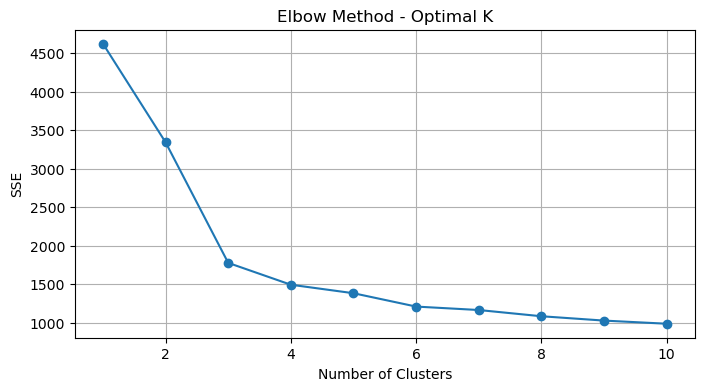

Silhouette Score for k=2: 0.4952
Silhouette Score for k=3: 0.4439
Silhouette Score for k=4: 0.3239
Silhouette Score for k=5: 0.2928


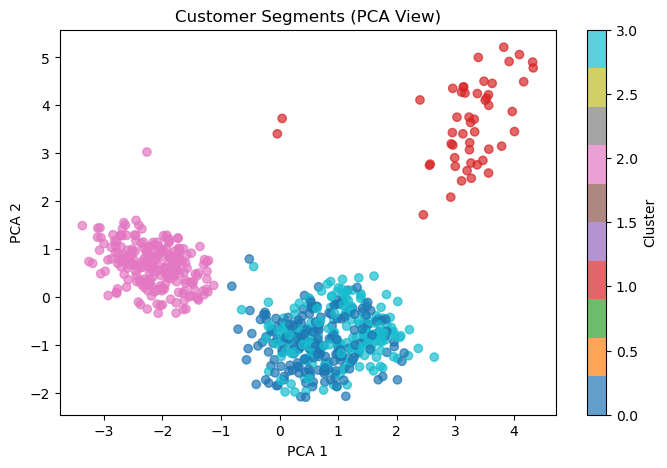


Linear Regression Performance:
R² Score: 0.7411
RMSE: 18511.29


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:

df = pd.read_csv("Credit Card Customer Data.csv")  # Use your downloaded path

if 'Customer_ID' in df.columns:
    df = df.drop('Customer_ID', axis=1)

df = df.dropna()

df_encoded = pd.get_dummies(df, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# K-Means Clustering 
# Elbow method to find optimal K
sse = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, sse, marker='o')
plt.title("Elbow Method - Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.grid()
plt.show()

#Silhouette score to validate
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for k={k}: {score:.4f}")

# Final clustering
optimal_k = 4  # Choose based on elbow/silhouette
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# plotting 

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['Cluster'], cmap='tab10', alpha=0.7)
plt.title("Customer Segments (PCA View)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()

# Linear Regression for Avg_Credit_Limit

df_lr = df_encoded.copy()

# target and features
target = "Avg_Credit_Limit"
X = df_lr.drop(columns=[target])
y = df_lr[target]

# Scaling 
X_scaled_lr = scaler.fit_transform(X)

# Traintest split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_lr, y, test_size=0.2, random_state=42)


reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"\nLinear Regression Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
